In [113]:
import scipy.io
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from scipy.linalg import norm

from tqdm.keras import TqdmCallback
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping

from itertools import product
from random import shuffle

from plot_keras_history import plot_history
import matplotlib.pyplot as plt

# import keras_tuner as kt
from keras.models import load_model

import matplotlib
from os.path import exists

from sklearn.metrics import mean_squared_error
import numpy as np

import seaborn as sns
import pandas as pd

from tensorflow.keras.models import load_model




np.random.seed(10)

In [114]:
clients = [1, 2, 3]
epochs = 5

In [115]:
data = scipy.io.loadmat("data.mat")

trainData = data["trainData"].transpose((3, 0, 1, 2))
trainLabels = data["trainLabels"].transpose((3, 0, 1, 2))
valData = data["valData"].transpose((3, 0, 1, 2))
valLabels = data["valLabels"].transpose((3, 0, 1, 2))

In [116]:
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split

# Load the data from the .mat file
data = scipy.io.loadmat("data.mat")
trainData = data["trainData"].transpose((3, 0, 1, 2))
trainLabels = data["trainLabels"].transpose((3, 0, 1, 2))
valData = data["valData"].transpose((3, 0, 1, 2))
valLabels = data["valLabels"].transpose((3, 0, 1, 2))

# Determine the number of clients
clients = [1, 2, 3]  # Example: 3 clients

# Generate a random permutation of indices
num_samples = len(trainData)
permutation = np.random.permutation(num_samples)

# Shuffle the training data and labels using the same permutation
shuffled_trainData = trainData[permutation]
shuffled_trainLabels = trainLabels[permutation]
X_train, X_test, y_train, y_test = train_test_split(
    trainData, trainLabels, test_size=0.2, random_state=42
)

# Split the shuffled training data into parts for each client
n_parts = len(clients)
part_size = len(X_train) // n_parts
dataset_parts = []
for i in range(n_parts):
    start = i * part_size
    end = (i + 1) * part_size
    X_part = X_train[start:end]
    y_part = y_train[start:end]
    dataset_parts.append((X_part, y_part))

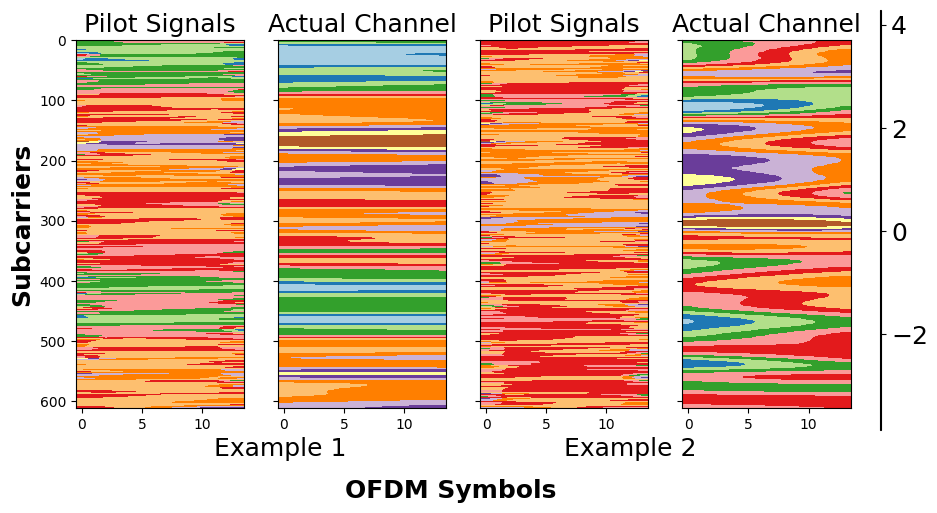

In [117]:
cmap_name = "Paired"
font_size = 18

rand_idx = np.random.randint(0, valData.shape[0], 2)

test_input1 = valData[rand_idx[0] : rand_idx[0] + 1, :]
real_output1 = valLabels[rand_idx[0] : rand_idx[0] + 1, :]

test_input2 = valData[rand_idx[1] : rand_idx[1] + 1, :]
real_output2 = valLabels[rand_idx[1] : rand_idx[1] + 1, :]

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 6), sharey=True)

im1 = ax[0].imshow(test_input1.reshape(612, 14), cmap=cmap_name)
ax[0].set_aspect(0.05)
ax[0].set_title("Pilot Signals", fontsize=font_size)

ax[1].imshow(real_output1.reshape(612, 14), cmap=cmap_name)
ax[1].set_aspect(0.05)
ax[1].set_title("Actual Channel", fontsize=font_size)

im1 = ax[2].imshow(test_input2.reshape(612, 14), cmap=cmap_name)
ax[2].set_aspect(0.05)
ax[2].set_title("Pilot Signals", fontsize=font_size)

ax[3].imshow(real_output2.reshape(612, 14), cmap=cmap_name)
ax[3].set_aspect(0.05)
ax[3].set_title("Actual Channel", fontsize=font_size)

ax[0].set_ylabel("Subcarriers", fontsize=font_size, fontweight="bold")
fig.text(
    0.5,
    0.05,
    "OFDM Symbols",
    ha="center",
    va="center",
    fontsize=font_size,
    fontweight="bold",
)
fig.text(
    0.33,
    0.12,
    "Example 1",
    ha="center",
    va="center",
    fontsize=font_size,
    fontweight="normal",
)
fig.text(
    0.68,
    0.12,
    "Example 2",
    ha="center",
    va="center",
    fontsize=font_size,
    fontweight="normal",
)

cbar_ax = fig.add_axes([0.92, 0.152, 0.02, 0.7])
fig.colorbar(im1, cax=cbar_ax)
cbar_ax.set_aspect(50.5)
cbar_ax.tick_params(labelsize=font_size)

# plt.show()

In [118]:
def get_model(mult_factor=1.0, model_name=""):
    model = models.Sequential(name=model_name)
    # selu, softplus, selu
    model.add(
        layers.Conv2D(
            int(48 * mult_factor),
            (9, 9),
            padding="same",
            activation="selu",
            input_shape=(612, 14, 1),
        )
    )
    model.add(
        layers.Conv2D(
            int(16 * mult_factor), (5, 5), padding="same", activation="softplus"
        )
    )
    model.add(layers.Conv2D(1, (5, 5), padding="same", activation="selu"))
    model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
    return model

In [119]:
# model = get_model(1.0, model_name="FL-model")

# es_teacher = EarlyStopping(
#     monitor="val_loss", patience=50, verbose=1, restore_best_weights=True, mode="min"
# )

# model.compile(optimizer="adam", loss="mse", metrics=["mse"])
# # Train and evaluate teacher on data.

# hist_model = model.fit(
#     trainData,
#     trainLabels,
#     epochs=10,
#     verbose=0,
#     batch_size=128,
#     callbacks=[es_teacher, TqdmCallback(verbose=1, desc="DL training")],
#     validation_data=(valData, valLabels),
# )

In [120]:
allmodels = []
for _ in range(len(clients)):
    allmodels.append(get_model())

In [121]:
import numpy as np
from Pyfhel import Pyfhel

HE = Pyfhel()  # Creating empty Pyfhel object
ckks_params = {
    "scheme": "CKKS",  # can also be 'ckks'
    "n": 2**14,  # Polynomial modulus degree. For CKKS, n/2 values can be
    #  encoded in a single ciphertext.
    #  Typ. 2^D for D in [10, 15]
    "scale": 2**30,  # All the encodings will use it for float->fixed point
    #  conversion: x_fix = round(x_float * scale)
    #  You can use this as default scale or use a different
    #  scale on each operation (set in HE.encryptFrac)
    "qi_sizes": [60, 30, 30, 30, 60],  # Number of bits of each prime in the chain.
    # Intermediate values should be  close to log2(scale)
    # for each operation, to have small rounding errors.
}
HE.contextGen(**ckks_params)  # Generate context for ckks scheme
HE.keyGen()  # Key Generation: generates a pair of public/secret keys
HE.rotateKeyGen()

In [122]:
def encrypt_wt(wtarray):
    cwt = []
    for layer in wtarray:
        flat_array = layer.astype(np.float64).flatten()

        chunks = np.array_split(flat_array, (len(flat_array) + 2**10 - 1) // 2**10)
        clayer = []
        for chunk in chunks:
            ptxt = HE.encodeFrac(chunk)
            ctxt = HE.encryptPtxt(ptxt)
            clayer.append(ctxt)
        cwt.append(clayer.copy())
    return cwt

In [123]:
def aggregate_wt(cwts):
    resmodel = []
    for j in range(len(cwts[0])):  # for layers
        layer = []
        for k in range(len(cwts[0][j])):  # for chunks
            tmp = cwts[0][j][k].copy()
            for i in range(1, len(cwts)):  # for clients
                tmp = tmp + cwts[i][j][k]
            tmp = tmp / len(cwts)
            layer.append(tmp)
        resmodel.append(layer)

    res = [resmodel.copy() for _ in range(len(clients))]
    return res

In [124]:
def decrypt_weights(res):
    decrypted_weights = []
    for client_weights, model in zip(res, allmodels):
        decrypted_client_weights = []
        wtarray = model.get_weights()
        for layer_weights, layer in zip(client_weights, wtarray):
            decrypted_layer_weights = []
            flat_array = layer.astype(np.float64).flatten()
            chunks = np.array_split(flat_array, (len(flat_array) + 2**10 - 1) // 2**10)
            for chunk, encrypted_chunk in zip(chunks, layer_weights):
                decrypted_chunk = HE.decryptFrac(encrypted_chunk)
                original_chunk_size = len(chunk)
                decrypted_chunk = decrypted_chunk[:original_chunk_size]
                decrypted_layer_weights.append(decrypted_chunk)
            decrypted_layer_weights = np.concatenate(decrypted_layer_weights, axis=0)
            decrypted_layer_weights = decrypted_layer_weights.reshape(layer.shape)
            decrypted_client_weights.append(decrypted_layer_weights)
        decrypted_weights.append(decrypted_client_weights)
    return decrypted_weights

In [125]:
m= get_model()

  0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 3s 722ms/step - loss: 0.7915 - accuracy: 0.0000e+00


  1%|          | 1/100 [00:10<17:40, 10.72s/it]

4/4 [==============================] - 3s 726ms/step - loss: 0.3050 - accuracy: 0.0000e+00


  2%|▏         | 2/100 [00:20<16:42, 10.23s/it]

4/4 [==============================] - 3s 723ms/step - loss: 0.1206 - accuracy: 0.0000e+00


  3%|▎         | 3/100 [00:30<16:19, 10.10s/it]

4/4 [==============================] - 3s 726ms/step - loss: 0.1023 - accuracy: 0.0000e+00


  4%|▍         | 4/100 [00:40<15:59, 10.00s/it]

4/4 [==============================] - 3s 735ms/step - loss: 0.0993 - accuracy: 0.0000e+00


  5%|▌         | 5/100 [00:50<15:46,  9.97s/it]

4/4 [==============================] - 3s 762ms/step - loss: 0.0785 - accuracy: 0.0000e+00


  6%|▌         | 6/100 [01:00<15:36,  9.96s/it]

4/4 [==============================] - 3s 709ms/step - loss: 0.0676 - accuracy: 0.0000e+00


  7%|▋         | 7/100 [01:10<15:22,  9.92s/it]

4/4 [==============================] - 3s 756ms/step - loss: 0.0669 - accuracy: 0.0000e+00


  8%|▊         | 8/100 [01:20<15:17,  9.97s/it]

4/4 [==============================] - 3s 737ms/step - loss: 0.0547 - accuracy: 0.0000e+00


  9%|▉         | 9/100 [01:30<15:17, 10.08s/it]

4/4 [==============================] - 3s 700ms/step - loss: 0.0520 - accuracy: 0.0000e+00


 10%|█         | 10/100 [01:40<14:58,  9.98s/it]

4/4 [==============================] - 3s 744ms/step - loss: 0.0476 - accuracy: 0.0000e+00


 11%|█         | 11/100 [01:50<14:45,  9.95s/it]

4/4 [==============================] - 3s 743ms/step - loss: 0.0448 - accuracy: 0.0000e+00


 12%|█▏        | 12/100 [02:00<14:38,  9.98s/it]

4/4 [==============================] - 3s 716ms/step - loss: 0.0422 - accuracy: 0.0000e+00


 13%|█▎        | 13/100 [02:09<14:21,  9.90s/it]

4/4 [==============================] - 3s 703ms/step - loss: 0.0409 - accuracy: 0.0000e+00


 14%|█▍        | 14/100 [02:19<14:10,  9.89s/it]

4/4 [==============================] - 3s 692ms/step - loss: 0.0397 - accuracy: 0.0000e+00


 15%|█▌        | 15/100 [02:29<13:58,  9.87s/it]

4/4 [==============================] - 3s 753ms/step - loss: 0.0385 - accuracy: 0.0000e+00


 16%|█▌        | 16/100 [02:39<13:51,  9.90s/it]

4/4 [==============================] - 3s 741ms/step - loss: 0.0375 - accuracy: 0.0000e+00


 17%|█▋        | 17/100 [02:49<13:43,  9.92s/it]

4/4 [==============================] - 3s 775ms/step - loss: 0.0368 - accuracy: 0.0000e+00


 18%|█▊        | 18/100 [02:59<13:39,  9.99s/it]

4/4 [==============================] - 3s 724ms/step - loss: 0.0362 - accuracy: 0.0000e+00


 19%|█▉        | 19/100 [03:09<13:31, 10.01s/it]

4/4 [==============================] - 3s 748ms/step - loss: 0.0356 - accuracy: 0.0000e+00


 20%|██        | 20/100 [03:19<13:25, 10.07s/it]

4/4 [==============================] - 3s 701ms/step - loss: 0.0351 - accuracy: 0.0000e+00


 21%|██        | 21/100 [03:29<13:12, 10.03s/it]

4/4 [==============================] - 3s 743ms/step - loss: 0.0348 - accuracy: 0.0000e+00


 22%|██▏       | 22/100 [03:39<13:01, 10.03s/it]

4/4 [==============================] - 3s 733ms/step - loss: 0.0343 - accuracy: 0.0000e+00


 23%|██▎       | 23/100 [03:49<12:49,  9.99s/it]

4/4 [==============================] - 3s 741ms/step - loss: 0.0343 - accuracy: 0.0000e+00


 24%|██▍       | 24/100 [03:59<12:41, 10.02s/it]

4/4 [==============================] - 3s 758ms/step - loss: 0.0343 - accuracy: 0.0000e+00


 25%|██▌       | 25/100 [04:10<12:34, 10.05s/it]

4/4 [==============================] - 3s 715ms/step - loss: 0.0338 - accuracy: 0.0000e+00


 26%|██▌       | 26/100 [04:20<12:23, 10.04s/it]

4/4 [==============================] - 3s 749ms/step - loss: 0.0336 - accuracy: 0.0000e+00


 27%|██▋       | 27/100 [04:30<12:15, 10.08s/it]

4/4 [==============================] - 3s 753ms/step - loss: 0.0333 - accuracy: 0.0000e+00


 28%|██▊       | 28/100 [04:40<12:07, 10.11s/it]

4/4 [==============================] - 3s 721ms/step - loss: 0.0329 - accuracy: 0.0000e+00


 29%|██▉       | 29/100 [04:50<11:58, 10.11s/it]

4/4 [==============================] - 3s 730ms/step - loss: 0.0327 - accuracy: 0.0000e+00


 30%|███       | 30/100 [05:00<11:46, 10.10s/it]

4/4 [==============================] - 3s 735ms/step - loss: 0.0326 - accuracy: 0.0000e+00


 31%|███       | 31/100 [05:10<11:35, 10.07s/it]

4/4 [==============================] - 3s 754ms/step - loss: 0.0325 - accuracy: 0.0000e+00


 32%|███▏      | 32/100 [05:20<11:26, 10.10s/it]

4/4 [==============================] - 3s 762ms/step - loss: 0.0323 - accuracy: 0.0000e+00


 33%|███▎      | 33/100 [05:30<11:19, 10.14s/it]

4/4 [==============================] - 3s 748ms/step - loss: 0.0321 - accuracy: 0.0000e+00


 34%|███▍      | 34/100 [05:41<11:12, 10.19s/it]

4/4 [==============================] - 3s 784ms/step - loss: 0.0321 - accuracy: 0.0000e+00


 35%|███▌      | 35/100 [05:51<11:07, 10.27s/it]

4/4 [==============================] - 3s 745ms/step - loss: 0.0320 - accuracy: 0.0000e+00


 36%|███▌      | 36/100 [06:01<10:56, 10.26s/it]

4/4 [==============================] - 3s 751ms/step - loss: 0.0320 - accuracy: 0.0000e+00


 37%|███▋      | 37/100 [06:12<10:47, 10.28s/it]

4/4 [==============================] - 3s 751ms/step - loss: 0.0318 - accuracy: 0.0000e+00


 38%|███▊      | 38/100 [06:22<10:37, 10.29s/it]

4/4 [==============================] - 3s 786ms/step - loss: 0.0316 - accuracy: 0.0000e+00


 39%|███▉      | 39/100 [06:33<10:30, 10.33s/it]

4/4 [==============================] - 3s 798ms/step - loss: 0.0316 - accuracy: 0.0000e+00


 40%|████      | 40/100 [06:43<10:21, 10.35s/it]

4/4 [==============================] - 3s 780ms/step - loss: 0.0315 - accuracy: 0.0000e+00


 41%|████      | 41/100 [06:53<10:08, 10.31s/it]

4/4 [==============================] - 3s 743ms/step - loss: 0.0314 - accuracy: 0.0000e+00


 42%|████▏     | 42/100 [07:03<09:56, 10.28s/it]

4/4 [==============================] - 3s 776ms/step - loss: 0.0312 - accuracy: 0.0000e+00


 43%|████▎     | 43/100 [07:14<09:48, 10.32s/it]

4/4 [==============================] - 3s 742ms/step - loss: 0.0311 - accuracy: 0.0000e+00


 44%|████▍     | 44/100 [07:24<09:37, 10.31s/it]

4/4 [==============================] - 3s 736ms/step - loss: 0.0310 - accuracy: 0.0000e+00


 45%|████▌     | 45/100 [07:34<09:26, 10.29s/it]

4/4 [==============================] - 3s 738ms/step - loss: 0.0311 - accuracy: 0.0000e+00


 46%|████▌     | 46/100 [07:44<09:11, 10.22s/it]

4/4 [==============================] - 3s 764ms/step - loss: 0.0309 - accuracy: 0.0000e+00


 47%|████▋     | 47/100 [07:55<09:04, 10.27s/it]

4/4 [==============================] - 3s 779ms/step - loss: 0.0307 - accuracy: 0.0000e+00


 48%|████▊     | 48/100 [08:05<08:53, 10.27s/it]

4/4 [==============================] - 3s 769ms/step - loss: 0.0306 - accuracy: 0.0000e+00


 49%|████▉     | 49/100 [08:15<08:41, 10.23s/it]

4/4 [==============================] - 3s 769ms/step - loss: 0.0308 - accuracy: 0.0000e+00


 50%|█████     | 50/100 [08:26<08:33, 10.28s/it]

4/4 [==============================] - 3s 731ms/step - loss: 0.0314 - accuracy: 0.0000e+00


 51%|█████     | 51/100 [08:36<08:19, 10.20s/it]

4/4 [==============================] - 3s 777ms/step - loss: 0.0308 - accuracy: 0.0000e+00


 52%|█████▏    | 52/100 [08:46<08:10, 10.22s/it]

4/4 [==============================] - 3s 750ms/step - loss: 0.0306 - accuracy: 0.0000e+00


 53%|█████▎    | 53/100 [08:56<08:03, 10.28s/it]

4/4 [==============================] - 3s 747ms/step - loss: 0.0306 - accuracy: 0.0000e+00


 54%|█████▍    | 54/100 [09:07<07:52, 10.28s/it]

4/4 [==============================] - 3s 783ms/step - loss: 0.0314 - accuracy: 0.0000e+00


 55%|█████▌    | 55/100 [09:17<07:43, 10.30s/it]

4/4 [==============================] - 3s 756ms/step - loss: 0.0315 - accuracy: 0.0000e+00


 56%|█████▌    | 56/100 [09:27<07:32, 10.28s/it]

4/4 [==============================] - 3s 748ms/step - loss: 0.0301 - accuracy: 0.0000e+00


 57%|█████▋    | 57/100 [09:37<07:22, 10.29s/it]

4/4 [==============================] - 3s 760ms/step - loss: 0.0299 - accuracy: 0.0000e+00


 58%|█████▊    | 58/100 [09:48<07:13, 10.32s/it]

4/4 [==============================] - 3s 752ms/step - loss: 0.0301 - accuracy: 0.0000e+00


 59%|█████▉    | 59/100 [09:58<07:02, 10.31s/it]

4/4 [==============================] - 3s 739ms/step - loss: 0.0301 - accuracy: 0.0000e+00


 60%|██████    | 60/100 [10:08<06:51, 10.29s/it]

4/4 [==============================] - 3s 743ms/step - loss: 0.0298 - accuracy: 0.0000e+00


 61%|██████    | 61/100 [10:18<06:39, 10.23s/it]

4/4 [==============================] - 3s 749ms/step - loss: 0.0298 - accuracy: 0.0000e+00


 62%|██████▏   | 62/100 [10:29<06:29, 10.25s/it]

4/4 [==============================] - 3s 771ms/step - loss: 0.0297 - accuracy: 0.0000e+00


 63%|██████▎   | 63/100 [10:39<06:18, 10.22s/it]

4/4 [==============================] - 3s 746ms/step - loss: 0.0297 - accuracy: 0.0000e+00


 64%|██████▍   | 64/100 [10:51<06:29, 10.83s/it]

4/4 [==============================] - 3s 794ms/step - loss: 0.0300 - accuracy: 0.0000e+00


 65%|██████▌   | 65/100 [11:01<06:12, 10.65s/it]

4/4 [==============================] - 3s 766ms/step - loss: 0.0302 - accuracy: 0.0000e+00


 66%|██████▌   | 66/100 [11:12<05:59, 10.57s/it]

4/4 [==============================] - 3s 752ms/step - loss: 0.0295 - accuracy: 0.0000e+00


 67%|██████▋   | 67/100 [11:22<05:47, 10.53s/it]

4/4 [==============================] - 3s 748ms/step - loss: 0.0296 - accuracy: 0.0000e+00


 68%|██████▊   | 68/100 [11:33<05:35, 10.47s/it]

4/4 [==============================] - 3s 792ms/step - loss: 0.0295 - accuracy: 0.0000e+00


 69%|██████▉   | 69/100 [11:43<05:23, 10.43s/it]

4/4 [==============================] - 3s 734ms/step - loss: 0.0299 - accuracy: 0.0000e+00


 70%|███████   | 70/100 [11:53<05:12, 10.40s/it]

4/4 [==============================] - 3s 750ms/step - loss: 0.0296 - accuracy: 0.0000e+00


 71%|███████   | 71/100 [12:03<05:00, 10.36s/it]

4/4 [==============================] - 3s 754ms/step - loss: 0.0296 - accuracy: 0.0000e+00


 72%|███████▏  | 72/100 [12:14<04:48, 10.29s/it]

4/4 [==============================] - 3s 743ms/step - loss: 0.0296 - accuracy: 0.0000e+00


 73%|███████▎  | 73/100 [12:24<04:37, 10.28s/it]

4/4 [==============================] - 3s 743ms/step - loss: 0.0292 - accuracy: 0.0000e+00


 74%|███████▍  | 74/100 [12:34<04:27, 10.27s/it]

4/4 [==============================] - 3s 721ms/step - loss: 0.0291 - accuracy: 0.0000e+00


 75%|███████▌  | 75/100 [12:44<04:16, 10.27s/it]

4/4 [==============================] - 3s 761ms/step - loss: 0.0290 - accuracy: 0.0000e+00


 76%|███████▌  | 76/100 [12:55<04:06, 10.29s/it]

4/4 [==============================] - 3s 751ms/step - loss: 0.0293 - accuracy: 0.0000e+00


 77%|███████▋  | 77/100 [13:05<03:55, 10.23s/it]

4/4 [==============================] - 3s 754ms/step - loss: 0.0292 - accuracy: 0.0000e+00


 78%|███████▊  | 78/100 [13:15<03:45, 10.25s/it]

4/4 [==============================] - 3s 753ms/step - loss: 0.0290 - accuracy: 0.0000e+00


 79%|███████▉  | 79/100 [13:25<03:35, 10.25s/it]

4/4 [==============================] - 3s 744ms/step - loss: 0.0289 - accuracy: 0.0000e+00


 80%|████████  | 80/100 [13:35<03:24, 10.21s/it]

4/4 [==============================] - 3s 774ms/step - loss: 0.0291 - accuracy: 0.0000e+00


 81%|████████  | 81/100 [13:46<03:14, 10.26s/it]

4/4 [==============================] - 3s 743ms/step - loss: 0.0290 - accuracy: 0.0000e+00


 82%|████████▏ | 82/100 [13:56<03:04, 10.23s/it]

4/4 [==============================] - 3s 730ms/step - loss: 0.0295 - accuracy: 0.0000e+00


 83%|████████▎ | 83/100 [14:06<02:54, 10.24s/it]

4/4 [==============================] - 3s 766ms/step - loss: 0.0296 - accuracy: 0.0000e+00


 84%|████████▍ | 84/100 [14:17<02:44, 10.28s/it]

4/4 [==============================] - 3s 773ms/step - loss: 0.0293 - accuracy: 0.0000e+00


 85%|████████▌ | 85/100 [14:27<02:34, 10.30s/it]

4/4 [==============================] - 3s 788ms/step - loss: 0.0296 - accuracy: 0.0000e+00


 86%|████████▌ | 86/100 [14:37<02:24, 10.31s/it]

4/4 [==============================] - 3s 762ms/step - loss: 0.0291 - accuracy: 0.0000e+00


 87%|████████▋ | 87/100 [14:48<02:14, 10.34s/it]

4/4 [==============================] - 3s 764ms/step - loss: 0.0287 - accuracy: 0.0000e+00


 88%|████████▊ | 88/100 [14:58<02:04, 10.34s/it]

4/4 [==============================] - 3s 750ms/step - loss: 0.0294 - accuracy: 0.0000e+00


 89%|████████▉ | 89/100 [15:08<01:53, 10.34s/it]

4/4 [==============================] - 3s 762ms/step - loss: 0.0287 - accuracy: 0.0000e+00


 90%|█████████ | 90/100 [15:21<01:49, 10.99s/it]

4/4 [==============================] - 3s 748ms/step - loss: 0.0288 - accuracy: 0.0000e+00


 91%|█████████ | 91/100 [15:31<01:37, 10.79s/it]

4/4 [==============================] - 3s 805ms/step - loss: 0.0288 - accuracy: 0.0000e+00


 92%|█████████▏| 92/100 [15:42<01:25, 10.73s/it]

4/4 [==============================] - 3s 767ms/step - loss: 0.0286 - accuracy: 0.0000e+00


 93%|█████████▎| 93/100 [15:52<01:13, 10.56s/it]

4/4 [==============================] - 3s 763ms/step - loss: 0.0288 - accuracy: 0.0000e+00


 94%|█████████▍| 94/100 [16:02<01:02, 10.44s/it]

4/4 [==============================] - 3s 780ms/step - loss: 0.0288 - accuracy: 0.0000e+00


 95%|█████████▌| 95/100 [16:13<00:52, 10.42s/it]

4/4 [==============================] - 3s 788ms/step - loss: 0.0287 - accuracy: 0.0000e+00


 96%|█████████▌| 96/100 [16:23<00:41, 10.49s/it]

4/4 [==============================] - 3s 751ms/step - loss: 0.0286 - accuracy: 0.0000e+00


 97%|█████████▋| 97/100 [16:34<00:31, 10.46s/it]

4/4 [==============================] - 3s 768ms/step - loss: 0.0287 - accuracy: 0.0000e+00


 98%|█████████▊| 98/100 [16:44<00:20, 10.46s/it]

4/4 [==============================] - 3s 840ms/step - loss: 0.0289 - accuracy: 0.0000e+00


 99%|█████████▉| 99/100 [16:54<00:10, 10.43s/it]

4/4 [==============================] - 3s 829ms/step - loss: 0.0298 - accuracy: 0.0000e+00


100%|██████████| 100/100 [17:05<00:00, 10.26s/it]


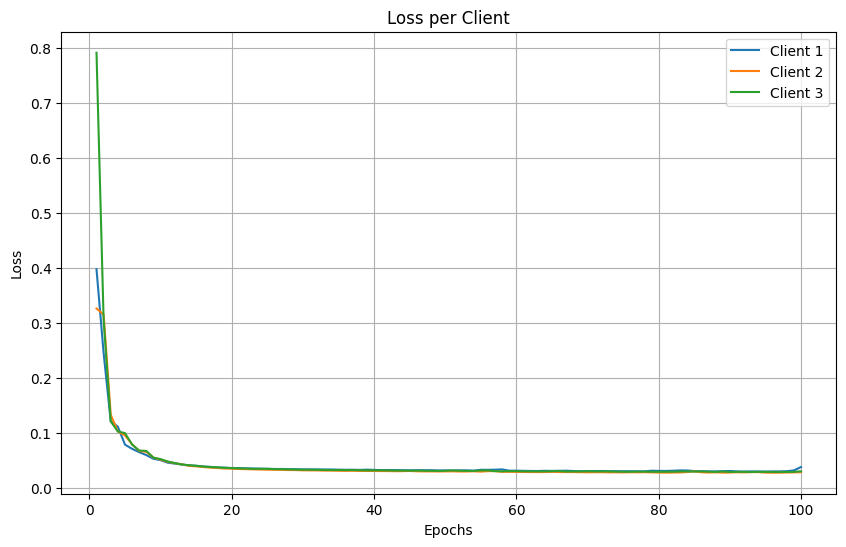

In [126]:
import matplotlib.pyplot as plt
from tqdm import tqdm

epochs = 100  # Number of epochs
num_clients = len(allmodels)  # Number of clients

# Initialize lists to store loss values for each client
client_losses = [[] for _ in range(num_clients)]

cwts = [encrypt_wt(model.get_weights()) for model in allmodels]

for e in tqdm(range(epochs)):
    wts = decrypt_weights(cwts)
    cwts = []

    for wt, model, dataset in zip(wts, allmodels, dataset_parts):
        model.set_weights(wt)
        history = model.fit(dataset[0], dataset[1], epochs=1, verbose=1)
        loss = history.history["loss"][0]
        client_losses[allmodels.index(model)].append(loss)

        wtarray = model.get_weights()
        cwts.append(encrypt_wt(wtarray))

    cwts = aggregate_wt(cwts)

# Plot the graph
plt.figure(figsize=(10, 6))
for i in range(num_clients):
    plt.plot(range(1, epochs + 1), client_losses[i], label=f"Client {i+1}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss per Client")
plt.legend()
plt.grid(True)
plt.show()

In [127]:
cwts = [encrypt_wt(model.get_weights()) for model in allmodels]
for e in tqdm(range(epochs)):
    wts = decrypt_weights(cwts)
    cwts = []
    for wt, model, dataset in zip(wts, allmodels, dataset_parts):
        model.set_weights(wt)
        model.fit(dataset[0], dataset[1], epochs=1, verbose=1)
        wtarray = model.get_weights()
        cwts.append(encrypt_wt(wtarray))

    cwts = aggregate_wt(cwts)

  0%|          | 0/100 [00:00<?, ?it/s]

4/4 [==============================] - 3s 730ms/step - loss: 0.0297 - accuracy: 0.0000e+00


  1%|          | 1/100 [00:09<16:26,  9.96s/it]

4/4 [==============================] - 3s 762ms/step - loss: 0.0290 - accuracy: 0.0000e+00


  2%|▏         | 2/100 [00:20<16:30, 10.11s/it]

4/4 [==============================] - 3s 771ms/step - loss: 0.0298 - accuracy: 0.0000e+00


  3%|▎         | 3/100 [00:30<16:22, 10.13s/it]

4/4 [==============================] - 3s 775ms/step - loss: 0.0303 - accuracy: 0.0000e+00


  4%|▍         | 4/100 [00:40<16:16, 10.17s/it]

4/4 [==============================] - 3s 748ms/step - loss: 0.0294 - accuracy: 0.0000e+00


  5%|▌         | 5/100 [00:50<16:10, 10.22s/it]

4/4 [==============================] - 3s 753ms/step - loss: 0.0287 - accuracy: 0.0000e+00


  6%|▌         | 6/100 [01:01<16:04, 10.26s/it]

4/4 [==============================] - 3s 747ms/step - loss: 0.0289 - accuracy: 0.0000e+00


  7%|▋         | 7/100 [01:11<15:58, 10.30s/it]

4/4 [==============================] - 3s 773ms/step - loss: 0.0293 - accuracy: 0.0000e+00


  8%|▊         | 8/100 [01:21<15:48, 10.31s/it]

4/4 [==============================] - 3s 724ms/step - loss: 0.0285 - accuracy: 0.0000e+00


  9%|▉         | 9/100 [01:31<15:28, 10.20s/it]

4/4 [==============================] - 3s 730ms/step - loss: 0.0291 - accuracy: 0.0000e+00


 10%|█         | 10/100 [01:42<15:16, 10.19s/it]

4/4 [==============================] - 3s 754ms/step - loss: 0.0287 - accuracy: 0.0000e+00


 11%|█         | 11/100 [01:52<15:09, 10.22s/it]

4/4 [==============================] - 3s 726ms/step - loss: 0.0284 - accuracy: 0.0000e+00


 12%|█▏        | 12/100 [02:02<14:55, 10.18s/it]

4/4 [==============================] - 3s 748ms/step - loss: 0.0282 - accuracy: 0.0000e+00


 13%|█▎        | 13/100 [02:12<14:43, 10.16s/it]

4/4 [==============================] - 3s 755ms/step - loss: 0.0284 - accuracy: 0.0000e+00


 14%|█▍        | 14/100 [02:22<14:31, 10.13s/it]

4/4 [==============================] - 3s 778ms/step - loss: 0.0283 - accuracy: 0.0000e+00


 15%|█▌        | 15/100 [02:32<14:20, 10.12s/it]

4/4 [==============================] - 3s 820ms/step - loss: 0.0282 - accuracy: 0.0000e+00


 16%|█▌        | 16/100 [02:43<14:18, 10.22s/it]

4/4 [==============================] - 3s 731ms/step - loss: 0.0282 - accuracy: 0.0000e+00


 17%|█▋        | 17/100 [02:53<14:04, 10.17s/it]

4/4 [==============================] - 3s 717ms/step - loss: 0.0286 - accuracy: 0.0000e+00


 18%|█▊        | 18/100 [03:03<13:54, 10.18s/it]

4/4 [==============================] - 3s 766ms/step - loss: 0.0291 - accuracy: 0.0000e+00


 19%|█▉        | 19/100 [03:13<13:45, 10.19s/it]

4/4 [==============================] - 3s 739ms/step - loss: 0.0286 - accuracy: 0.0000e+00


 20%|██        | 20/100 [03:24<13:42, 10.29s/it]

4/4 [==============================] - 3s 812ms/step - loss: 0.0282 - accuracy: 0.0000e+00


 21%|██        | 21/100 [03:34<13:32, 10.28s/it]

4/4 [==============================] - 3s 718ms/step - loss: 0.0283 - accuracy: 0.0000e+00


 22%|██▏       | 22/100 [03:44<13:15, 10.20s/it]

4/4 [==============================] - 3s 725ms/step - loss: 0.0285 - accuracy: 0.0000e+00


 23%|██▎       | 23/100 [03:54<13:03, 10.17s/it]

4/4 [==============================] - 3s 784ms/step - loss: 0.0283 - accuracy: 0.0000e+00


 24%|██▍       | 24/100 [04:04<12:57, 10.22s/it]

4/4 [==============================] - 3s 754ms/step - loss: 0.0282 - accuracy: 0.0000e+00


 25%|██▌       | 25/100 [04:15<12:49, 10.26s/it]

4/4 [==============================] - 3s 776ms/step - loss: 0.0282 - accuracy: 0.0000e+00


 26%|██▌       | 26/100 [04:25<12:48, 10.39s/it]

4/4 [==============================] - 3s 756ms/step - loss: 0.0281 - accuracy: 0.0000e+00


 27%|██▋       | 27/100 [04:36<12:40, 10.41s/it]

4/4 [==============================] - 3s 740ms/step - loss: 0.0282 - accuracy: 0.0000e+00


 28%|██▊       | 28/100 [04:46<12:26, 10.37s/it]

4/4 [==============================] - 3s 715ms/step - loss: 0.0283 - accuracy: 0.0000e+00


 29%|██▉       | 29/100 [04:56<12:12, 10.31s/it]

4/4 [==============================] - 3s 771ms/step - loss: 0.0285 - accuracy: 0.0000e+00


 30%|███       | 30/100 [05:07<12:01, 10.31s/it]

4/4 [==============================] - 3s 799ms/step - loss: 0.0291 - accuracy: 0.0000e+00


 31%|███       | 31/100 [05:17<11:56, 10.38s/it]

4/4 [==============================] - 3s 789ms/step - loss: 0.0291 - accuracy: 0.0000e+00


 32%|███▏      | 32/100 [05:28<11:47, 10.40s/it]

4/4 [==============================] - 3s 821ms/step - loss: 0.0285 - accuracy: 0.0000e+00


 33%|███▎      | 33/100 [05:38<11:43, 10.50s/it]

4/4 [==============================] - 3s 860ms/step - loss: 0.0282 - accuracy: 0.0000e+00


 34%|███▍      | 34/100 [05:49<11:41, 10.62s/it]

4/4 [==============================] - 3s 877ms/step - loss: 0.0284 - accuracy: 0.0000e+00


 35%|███▌      | 35/100 [06:00<11:33, 10.67s/it]

4/4 [==============================] - 3s 762ms/step - loss: 0.0285 - accuracy: 0.0000e+00


 36%|███▌      | 36/100 [06:11<11:19, 10.62s/it]

4/4 [==============================] - 3s 726ms/step - loss: 0.0286 - accuracy: 0.0000e+00


 37%|███▋      | 37/100 [06:21<11:09, 10.62s/it]

4/4 [==============================] - 3s 781ms/step - loss: 0.0285 - accuracy: 0.0000e+00


 38%|███▊      | 38/100 [06:32<10:55, 10.57s/it]

4/4 [==============================] - 3s 763ms/step - loss: 0.0281 - accuracy: 0.0000e+00


 39%|███▉      | 39/100 [06:42<10:46, 10.59s/it]

4/4 [==============================] - 3s 779ms/step - loss: 0.0280 - accuracy: 0.0000e+00


 40%|████      | 40/100 [06:53<10:35, 10.60s/it]

4/4 [==============================] - 3s 848ms/step - loss: 0.0283 - accuracy: 0.0000e+00


 41%|████      | 41/100 [07:04<10:25, 10.61s/it]

4/4 [==============================] - 3s 745ms/step - loss: 0.0281 - accuracy: 0.0000e+00


 42%|████▏     | 42/100 [07:14<10:14, 10.60s/it]

4/4 [==============================] - 3s 763ms/step - loss: 0.0281 - accuracy: 0.0000e+00


 43%|████▎     | 43/100 [07:24<09:59, 10.52s/it]

4/4 [==============================] - 3s 757ms/step - loss: 0.0281 - accuracy: 0.0000e+00


 44%|████▍     | 44/100 [07:35<09:48, 10.52s/it]

4/4 [==============================] - 3s 855ms/step - loss: 0.0279 - accuracy: 0.0000e+00


 45%|████▌     | 45/100 [07:46<09:44, 10.63s/it]

4/4 [==============================] - 3s 843ms/step - loss: 0.0282 - accuracy: 0.0000e+00


 46%|████▌     | 46/100 [07:57<09:37, 10.70s/it]

4/4 [==============================] - 3s 846ms/step - loss: 0.0280 - accuracy: 0.0000e+00


 47%|████▋     | 47/100 [08:08<09:30, 10.77s/it]

4/4 [==============================] - 3s 848ms/step - loss: 0.0279 - accuracy: 0.0000e+00


 48%|████▊     | 48/100 [08:18<09:20, 10.77s/it]

4/4 [==============================] - 3s 862ms/step - loss: 0.0279 - accuracy: 0.0000e+00


 49%|████▉     | 49/100 [08:30<09:17, 10.93s/it]

4/4 [==============================] - 3s 840ms/step - loss: 0.0280 - accuracy: 0.0000e+00


 50%|█████     | 50/100 [08:41<09:15, 11.10s/it]

4/4 [==============================] - 3s 824ms/step - loss: 0.0278 - accuracy: 0.0000e+00


 51%|█████     | 51/100 [08:53<09:07, 11.17s/it]

4/4 [==============================] - 3s 811ms/step - loss: 0.0279 - accuracy: 0.0000e+00


 52%|█████▏    | 52/100 [09:04<08:57, 11.19s/it]

4/4 [==============================] - 3s 795ms/step - loss: 0.0287 - accuracy: 0.0000e+00


 53%|█████▎    | 53/100 [09:15<08:39, 11.06s/it]

4/4 [==============================] - 3s 831ms/step - loss: 0.0290 - accuracy: 0.0000e+00


 54%|█████▍    | 54/100 [09:26<08:29, 11.08s/it]

4/4 [==============================] - 3s 790ms/step - loss: 0.0282 - accuracy: 0.0000e+00


 55%|█████▌    | 55/100 [09:37<08:20, 11.12s/it]

4/4 [==============================] - 3s 862ms/step - loss: 0.0278 - accuracy: 0.0000e+00


 56%|█████▌    | 56/100 [09:48<08:10, 11.16s/it]

4/4 [==============================] - 3s 858ms/step - loss: 0.0280 - accuracy: 0.0000e+00


 57%|█████▋    | 57/100 [10:00<08:05, 11.29s/it]

4/4 [==============================] - 4s 897ms/step - loss: 0.0284 - accuracy: 0.0000e+00


 58%|█████▊    | 58/100 [10:11<07:56, 11.35s/it]

4/4 [==============================] - 3s 836ms/step - loss: 0.0280 - accuracy: 0.0000e+00


 59%|█████▉    | 59/100 [10:22<07:43, 11.30s/it]

4/4 [==============================] - 4s 916ms/step - loss: 0.0284 - accuracy: 0.0000e+00


 60%|██████    | 60/100 [10:34<07:38, 11.46s/it]

4/4 [==============================] - 4s 890ms/step - loss: 0.0280 - accuracy: 0.0000e+00


 61%|██████    | 61/100 [10:46<07:30, 11.56s/it]

4/4 [==============================] - 3s 836ms/step - loss: 0.0280 - accuracy: 0.0000e+00


 62%|██████▏   | 62/100 [10:58<07:18, 11.55s/it]

4/4 [==============================] - 4s 888ms/step - loss: 0.0280 - accuracy: 0.0000e+00


 63%|██████▎   | 63/100 [11:09<07:05, 11.51s/it]

4/4 [==============================] - 4s 876ms/step - loss: 0.0280 - accuracy: 0.0000e+00


 64%|██████▍   | 64/100 [11:21<06:54, 11.52s/it]

4/4 [==============================] - 4s 928ms/step - loss: 0.0279 - accuracy: 0.0000e+00


 65%|██████▌   | 65/100 [11:32<06:45, 11.58s/it]

4/4 [==============================] - 4s 881ms/step - loss: 0.0280 - accuracy: 0.0000e+00


 66%|██████▌   | 66/100 [11:44<06:38, 11.73s/it]

4/4 [==============================] - 4s 926ms/step - loss: 0.0283 - accuracy: 0.0000e+00


 67%|██████▋   | 67/100 [11:57<06:33, 11.93s/it]

4/4 [==============================] - 3s 858ms/step - loss: 0.0289 - accuracy: 0.0000e+00


 68%|██████▊   | 68/100 [12:09<06:21, 11.92s/it]

4/4 [==============================] - 3s 889ms/step - loss: 0.0289 - accuracy: 0.0000e+00


 69%|██████▉   | 69/100 [12:20<06:09, 11.91s/it]

4/4 [==============================] - 4s 909ms/step - loss: 0.0284 - accuracy: 0.0000e+00


 70%|███████   | 70/100 [12:32<05:57, 11.93s/it]

4/4 [==============================] - 4s 867ms/step - loss: 0.0279 - accuracy: 0.0000e+00


 71%|███████   | 71/100 [12:44<05:46, 11.94s/it]

4/4 [==============================] - 4s 852ms/step - loss: 0.0281 - accuracy: 0.0000e+00


 72%|███████▏  | 72/100 [12:56<05:31, 11.85s/it]

4/4 [==============================] - 4s 918ms/step - loss: 0.0288 - accuracy: 0.0000e+00


 73%|███████▎  | 73/100 [13:08<05:17, 11.74s/it]

4/4 [==============================] - 4s 928ms/step - loss: 0.0284 - accuracy: 0.0000e+00


 74%|███████▍  | 74/100 [13:20<05:08, 11.86s/it]

4/4 [==============================] - 4s 923ms/step - loss: 0.0283 - accuracy: 0.0000e+00


 75%|███████▌  | 75/100 [13:32<04:56, 11.87s/it]

4/4 [==============================] - 4s 917ms/step - loss: 0.0279 - accuracy: 0.0000e+00


 76%|███████▌  | 76/100 [13:44<04:46, 11.92s/it]

4/4 [==============================] - 4s 928ms/step - loss: 0.0279 - accuracy: 0.0000e+00


 77%|███████▋  | 77/100 [13:56<04:36, 12.01s/it]

4/4 [==============================] - 4s 919ms/step - loss: 0.0282 - accuracy: 0.0000e+00


 78%|███████▊  | 78/100 [14:08<04:24, 12.03s/it]

4/4 [==============================] - 4s 929ms/step - loss: 0.0277 - accuracy: 0.0000e+00


 79%|███████▉  | 79/100 [14:20<04:12, 12.03s/it]

4/4 [==============================] - 4s 939ms/step - loss: 0.0277 - accuracy: 0.0000e+00


 80%|████████  | 80/100 [14:32<04:02, 12.14s/it]

4/4 [==============================] - 4s 904ms/step - loss: 0.0281 - accuracy: 0.0000e+00


 81%|████████  | 81/100 [14:45<03:51, 12.17s/it]

4/4 [==============================] - 4s 901ms/step - loss: 0.0285 - accuracy: 0.0000e+00


 82%|████████▏ | 82/100 [14:57<03:39, 12.19s/it]

4/4 [==============================] - 4s 899ms/step - loss: 0.0281 - accuracy: 0.0000e+00


 83%|████████▎ | 83/100 [15:09<03:27, 12.20s/it]

4/4 [==============================] - 4s 964ms/step - loss: 0.0281 - accuracy: 0.0000e+00


 84%|████████▍ | 84/100 [15:21<03:14, 12.14s/it]

4/4 [==============================] - 4s 932ms/step - loss: 0.0289 - accuracy: 0.0000e+00


 85%|████████▌ | 85/100 [15:33<03:01, 12.10s/it]

4/4 [==============================] - 4s 928ms/step - loss: 0.0289 - accuracy: 0.0000e+00


 86%|████████▌ | 86/100 [15:45<02:48, 12.05s/it]

4/4 [==============================] - 4s 912ms/step - loss: 0.0280 - accuracy: 0.0000e+00


 87%|████████▋ | 87/100 [15:57<02:36, 12.07s/it]

4/4 [==============================] - 4s 942ms/step - loss: 0.0279 - accuracy: 0.0000e+00


 88%|████████▊ | 88/100 [16:09<02:24, 12.08s/it]

4/4 [==============================] - 4s 893ms/step - loss: 0.0279 - accuracy: 0.0000e+00


 89%|████████▉ | 89/100 [16:21<02:12, 12.09s/it]

4/4 [==============================] - 3s 886ms/step - loss: 0.0278 - accuracy: 0.0000e+00


 90%|█████████ | 90/100 [16:33<02:00, 12.04s/it]

4/4 [==============================] - 3s 846ms/step - loss: 0.0276 - accuracy: 0.0000e+00


 91%|█████████ | 91/100 [16:45<01:47, 11.97s/it]

4/4 [==============================] - 4s 932ms/step - loss: 0.0278 - accuracy: 0.0000e+00


 92%|█████████▏| 92/100 [16:57<01:35, 11.99s/it]

4/4 [==============================] - 4s 893ms/step - loss: 0.0277 - accuracy: 0.0000e+00


 93%|█████████▎| 93/100 [17:09<01:23, 11.99s/it]

4/4 [==============================] - 4s 961ms/step - loss: 0.0275 - accuracy: 0.0000e+00


 94%|█████████▍| 94/100 [17:21<01:12, 12.08s/it]

4/4 [==============================] - 4s 936ms/step - loss: 0.0276 - accuracy: 0.0000e+00


 95%|█████████▌| 95/100 [17:34<01:00, 12.12s/it]

4/4 [==============================] - 4s 880ms/step - loss: 0.0282 - accuracy: 0.0000e+00


 96%|█████████▌| 96/100 [17:46<00:48, 12.14s/it]

4/4 [==============================] - 4s 902ms/step - loss: 0.0281 - accuracy: 0.0000e+00


 97%|█████████▋| 97/100 [17:58<00:36, 12.11s/it]

4/4 [==============================] - 4s 876ms/step - loss: 0.0279 - accuracy: 0.0000e+00


 98%|█████████▊| 98/100 [18:10<00:24, 12.02s/it]

4/4 [==============================] - 4s 941ms/step - loss: 0.0275 - accuracy: 0.0000e+00


 99%|█████████▉| 99/100 [18:22<00:12, 12.06s/it]

4/4 [==============================] - 4s 886ms/step - loss: 0.0276 - accuracy: 0.0000e+00


100%|██████████| 100/100 [18:34<00:00, 11.14s/it]


1/1 [==============================] - 0s 16ms/step


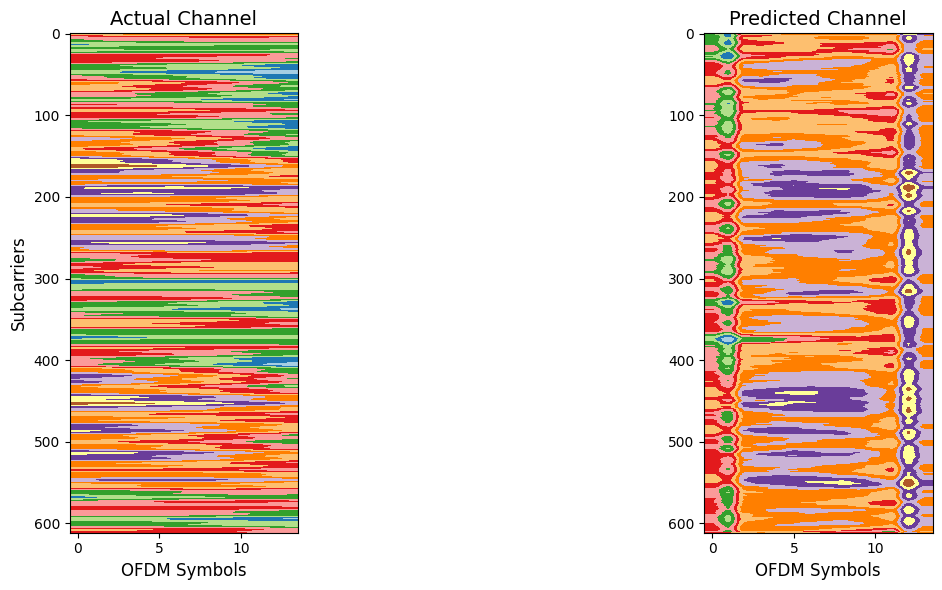

In [128]:
# Plot predicted vs. actual channel
rand_idx = np.random.randint(0, valData.shape[0])
test_input = valData[rand_idx : rand_idx + 1, :]
real_output = valLabels[rand_idx : rand_idx + 1, :]

predicted_output = aggregated_model.predict(test_input)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
im1 = ax[0].imshow(real_output.reshape(612, 14), cmap="Paired")
ax[0].set_aspect(0.05)
ax[0].set_title("Actual Channel", fontsize=14)
ax[0].set_ylabel("Subcarriers", fontsize=12)
ax[0].set_xlabel("OFDM Symbols", fontsize=12)

im2 = ax[1].imshow(predicted_output.reshape(612, 14), cmap="Paired")
ax[1].set_aspect(0.05)
ax[1].set_title("Predicted Channel", fontsize=14)
ax[1].set_xlabel("OFDM Symbols", fontsize=12)

plt.tight_layout()
plt.show()

In [129]:
# Calculate client-wise performance metrics
for client in clients:
    client_model = get_model()
    client_model.set_weights(wts[client - 1])
    loss, accuracy = client_model.evaluate(valData, valLabels, verbose=0)
    print(f"Client {client} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

Client 1 - Loss: 0.0297, Accuracy: 0.0000
Client 2 - Loss: 0.0297, Accuracy: 0.0000
Client 3 - Loss: 0.0297, Accuracy: 0.0000


ValueError: x and y must have same first dimension, but have shapes (100,) and (5,)

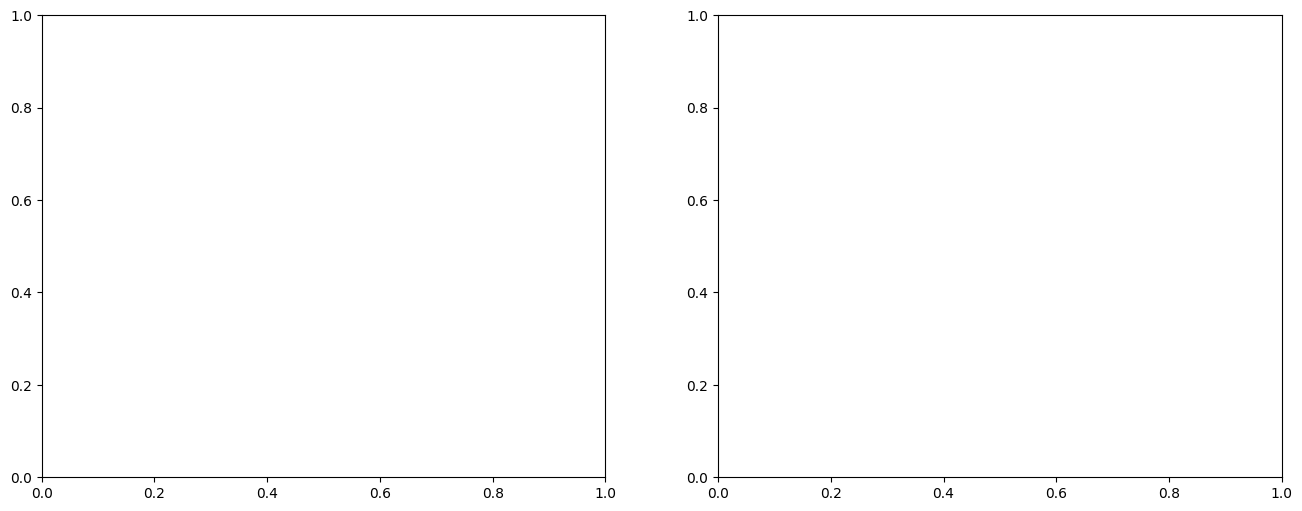

In [130]:
# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
epochs_range = range(1, epochs + 1)

# Plot loss
ax1.plot(
    epochs_range, aggregate_loss, label="Aggregated Model", linewidth=2, marker="o"
)
for client, loss_values in client_loss.items():
    ax1.plot(
        epochs_range,
        loss_values,
        label=f"Client {client}",
        linewidth=2,
        linestyle="--",
        marker="o",
    )
ax1.set_xlabel("Epoch", fontsize=14)
ax1.set_ylabel("Loss", fontsize=14)
ax1.set_title("Training Loss", fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True)

# Plot accuracy
ax2.plot(
    epochs_range, aggregate_accuracy, label="Aggregated Model", linewidth=2, marker="o"
)
for client, accuracy_values in client_accuracy.items():
    ax2.plot(
        epochs_range,
        accuracy_values,
        label=f"Client {client}",
        linewidth=2,
        linestyle="--",
        marker="o",
    )
ax2.set_xlabel("Epoch", fontsize=14)
ax2.set_ylabel("Accuracy", fontsize=14)
ax2.set_title("Training Accuracy", fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True)

plt.tight_layout()
plt.show()

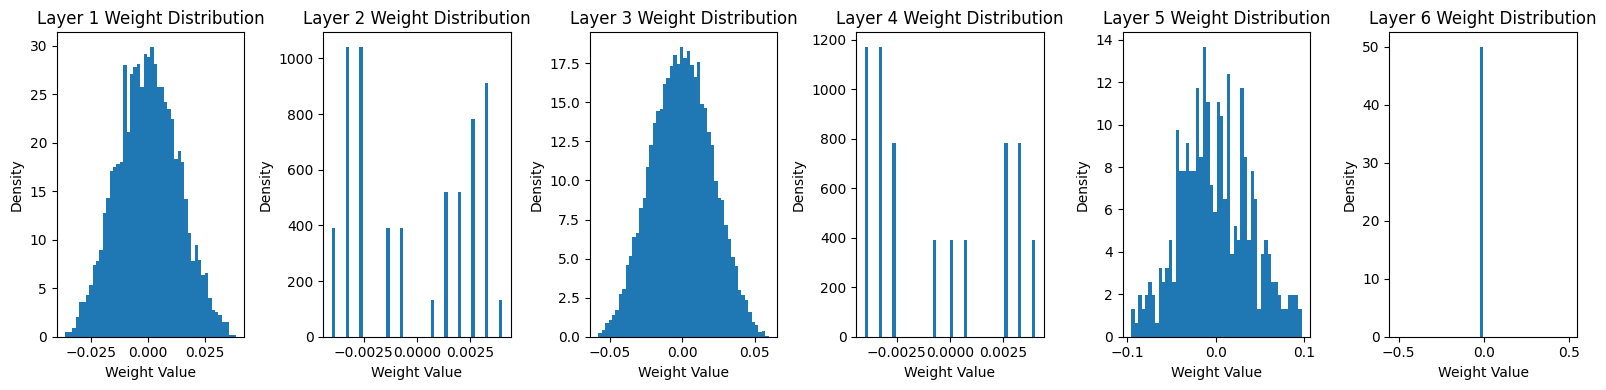

In [ ]:
# Plot weight distribution
num_layers = len(wts[0])
fig, axes = plt.subplots(1, num_layers, figsize=(16, 4))
for i in range(num_layers):
    layer_weights = wts[0][i].flatten()
    axes[i].hist(layer_weights, bins=50, density=True)
    axes[i].set_title(f"Layer {i+1} Weight Distribution", fontsize=12)
    axes[i].set_xlabel("Weight Value", fontsize=10)
    axes[i].set_ylabel("Density", fontsize=10)
plt.tight_layout()
plt.show()

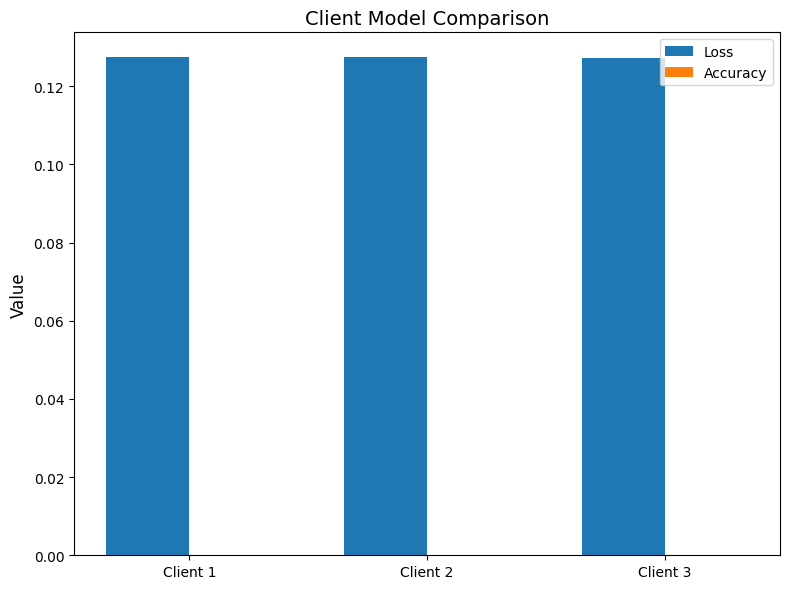

In [ ]:
# Compare client models
fig, ax = plt.subplots(figsize=(8, 6))
x = np.arange(len(clients))
width = 0.35
loss_values = [client_loss[client][-1] for client in clients]
accuracy_values = [client_accuracy[client][-1] for client in clients]
rects1 = ax.bar(x - width / 2, loss_values, width, label="Loss")
rects2 = ax.bar(x + width / 2, accuracy_values, width, label="Accuracy")
ax.set_xticks(x)
ax.set_xticklabels([f"Client {client}" for client in clients])
ax.set_ylabel("Value", fontsize=12)
ax.set_title("Client Model Comparison", fontsize=14)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

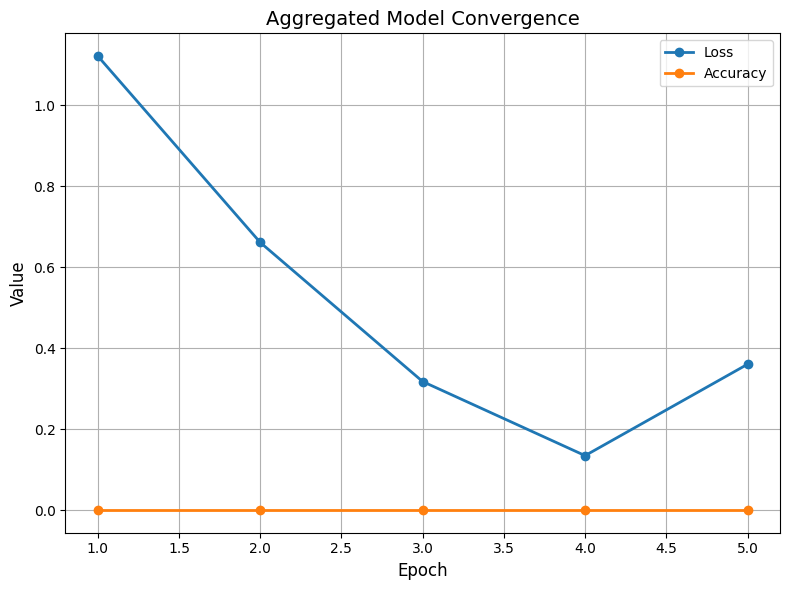

In [ ]:
# Plot aggregated model convergence
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(epochs_range, aggregate_loss, label="Loss", linewidth=2, marker="o")
ax.plot(epochs_range, aggregate_accuracy, label="Accuracy", linewidth=2, marker="o")
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Value", fontsize=12)
ax.set_title("Aggregated Model Convergence", fontsize=14)
ax.legend(fontsize=10)
ax.grid(True)
plt.tight_layout()
plt.show()